In [0]:
import numpy as np
import pandas as pd
import numpy.linalg as lng
from sympy import Matrix
import math

## Part 0: Declare Initial Values

Declare initial values for:
- $\mu$ = $\begin{pmatrix} .02\\ .07\\ .15\\ .20 \end{pmatrix}$
- $\sigma$ = $\begin{pmatrix} .05\\ .12\\ .17\\ .25 \end{pmatrix}$
- $R$ = $\begin{pmatrix} 1 & .3 & .3 & .3\\ .3 & 1 & .6 & .6 \\ .3 & .6 & 1 & .6 \\ .3 & .6 & .6 & 1 \\ \end{pmatrix}$
- $m$(Expected Return) = $0.045$

In [0]:
mu_value = [.02, .07, .15, .20]
sig_value = [.05, .12, .17, .25]
cor_values = [[1, .3, .3, .3],
              [.3, 1, .6, .6],
              [.3, .6, 1, .6],
              [.3, .6, .6, 1]
              ]   
m = 0.045

In [0]:
# Convert lists to np.arrays for fast matrix calculation
mu, sig, one_mtx = np.array(mu_value), np.diag(sig_value), np.ones(4)


## Part 1: Calculate Optimal Weight Matrix

Create a function to:
- Find $\Sigma$ and ${\Sigma}^{-1}$(Covariance and Inverse Covariance Matrix)
- Find $A, B, C$
- Find $\lambda$ and $\gamma$
- Find $\lambda\mu$
- Find $\gamma$ vector

In [0]:
# Get Covariance and InverseCovariance Matrix for given factor(1, 1.25, 1.5)
def get_cov_mtx_for(factor=1):
  cov = np.matmul(np.matmul(sig, np.array(cor_values) * factor), sig)
  inv_cov = Matrix.inv(Matrix(cov))
  return cov, inv_cov

# Get Constant values from Inverse Covariance matrix and mu
def get_ABC_values_for(inv_cov):
  A = np.matmul(np.matmul(np.transpose(one_mtx), inv_cov), one_mtx)
  B = np.matmul(np.matmul(np.transpose(mu), inv_cov), one_mtx)
  C = np.matmul(np.matmul(np.transpose(mu), inv_cov), mu)

  return A,B,C

# Get Lambda and Gamma values(Lagrangian Multiplier)
get_lambda_from = lambda x, A,B,C: (A * x - B)/(A * C - B**2)
get_gamma_from = lambda x,A,B,C : (C - B * x)/(A * C - B**2)

# Get Lambda mu, and Gamma vector
get_lamda_mu_for = lambda x : get_lambda_from(x,A,B,C) * mu
get_gamma_vec_for = lambda x, A, B, C : get_gamma_from(x,A,B,C) * one_mtx

# Get the optimal weight matrix for a given target return and factor
def get_weight_matrix_for(x, target_ret):
  cov_mtx, inv_cov_mtx = get_cov_mtx_for(x)
  A,B,C = get_ABC_values_for(inv_cov_mtx)
  
  LG = get_lambda_from(target_ret,A,B,C) * mu + get_gamma_vec_for(target_ret,A,B,C)
  return np.matmul(inv_cov_mtx, LG) 


### Part 1.1: Calculate weight Matrix for Covariance factor of 1, 1.25, 1.5

In [0]:
[get_weight_matrix_for(x, m) for x in [1,1.25,1.5]]

[array([0.785110661757705, 0.0538641896251522, 0.133554724646863,
        0.0274704239702789], dtype=object),
 array([0.785110661757705, 0.0538641896251527, 0.133554724646863,
        0.0274704239702788], dtype=object),
 array([0.785110661757706, 0.0538641896251528, 0.133554724646863,
        0.0274704239702788], dtype=object)]

### Part 1.2: Simulate for 2000 data points(Target Return) with Covariance factor 1

In [0]:
m_simulation =  np.arange(1,101)/1000
weights_sim = [get_weight_matrix_for(1, x) for x in m_simulation]
cov_mtx, _ = get_cov_mtx_for(1)

df = pd.DataFrame(weights_sim, index=m_simulation)
df.reset_index(inplace=True)
df.columns = "target_m asset_1 asset_2 asset_3 asset_4".split()
df["Total"] = df.asset_1+df.asset_2+df.asset_3+df.asset_4
# df.style.format({'target_m': "{:.2%}", 'asset_1': "{:.2%}",'asset_2': "{:.2%}",'asset_3': "{:.2%}",'asset_4': "{:.2%}"})

def calc(row):
  r = np.array([row.asset_1, row.asset_1, row.asset_3, row.asset_4])
  return np.matmul(np.matmul(r.transpose(), cov_mtx), r)**0.5

df["std"] = df.apply(lambda x : calc(x), axis=1)
df.loc[44:50,]

,target_m,asset_1,asset_2,asset_3,asset_4,Total,std
44,0.045,0.785110661757705,0.0538641896251522,0.133554724646863,0.0274704239702789,1.00000000000000,0.132006550338105
45,0.046,0.779664617173925,0.0518564597576469,0.138380582803986,0.0300983402644413,0.999999999999999,0.132272902902406
46,0.047,0.774218572590144,0.0498487298901416,0.143206440961110,0.0327262565586036,0.999999999999999,0.132545959322990
47,0.048,0.768772528006364,0.0478410000226361,0.148032299118233,0.0353541728527659,0.999999999999999,0.132825678255501
48,0.049,0.763326483422583,0.0458332701551308,0.152858157275357,0.0379820891469282,0.999999999999999,0.133112017698536
49,0.050,0.757880438838803,0.0438255402876256,0.157684015432480,0.0406100054410906,1.00000000000000,0.133404935021448
50,0.051,0.752434394255022,0.0418178104201203,0.162509873589604,0.0432379217352528,0.999999999999999,0.133704386992116


## Part 2: Plot the Efficient Frontier

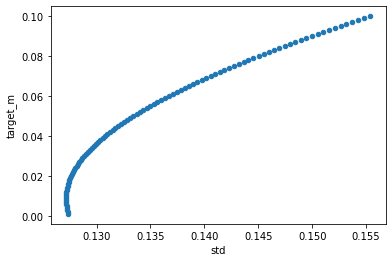

In [0]:
df.target_m = df.target_m.astype(float)
df["std"] = df["std"].astype(float)
df.plot.scatter(x="std", y="target_m")